In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# constants
BATCH_SIZE = 2048
target_mean = 0.5 # for normalizing image data
target_std = 0.5 # for normalizing image data
ENCODING_SIZE = 32

## Load data

In [3]:
initial_transform = transforms.Compose([transforms.ToTensor(),])
initial_dataset = datasets.MNIST(root='./data', train=True, transform=initial_transform, download=True)
initial_loader = torch.utils.data.DataLoader(initial_dataset, batch_size=len(initial_dataset))

In [4]:
data = next(iter(initial_loader))[0] # gets the entire dataset
current_mean = data.mean().item()
current_std = data.std().item()

In [5]:
print(f"{data.shape = }")
print(f"{current_mean = }")
print(f"{current_std = }")

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.13066047430038452
current_std = 0.30810782313346863


In [6]:
transform_mean = (current_mean * target_std - target_mean * current_std) / target_std
transform_std = current_std / target_std

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((transform_mean,), (transform_std,)),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
# test statistics (make sure mean and median are 0.5 and 0.5)
statistics_test_loader = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
statistics_test_loader = torch.utils.data.DataLoader(statistics_test_loader, batch_size=len(statistics_test_loader))
data = next(iter(statistics_test_loader))[0] # gets the normalized entire dataset
current_mean = data.mean().item()
current_std = data.std().item()
print(f"{data.shape = }")
print(f"{current_mean = }") # confirm mean ~0.5
print(f"{current_std = }")  # confirm std  ~0.5

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.4999999701976776
current_std = 0.4999999701976776


## Training

In [140]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [156]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, ENCODING_SIZE)
        )
        self.decoder = nn.Sequential(
            nn.Linear(ENCODING_SIZE, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=False),
        )

    def forward(self, x):
        encoding = self.encoder(x)
        # TODO: masking
        logits = self.decoder(encoding)
        return encoding, logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=False)
  )
)


In [157]:
l1_loss = nn.L1Loss()
def loss_fn(X, X_hat, encoding, lambda_term=0.003, gamma=0.01):
    # Mean absolute error for reconstruction
    mae_reconstruction = l1_loss(X, X_hat)
    
    # L1 norm for encoding
    encoding_loss = torch.norm(encoding, p=1) * lambda_term * (1/BATCH_SIZE)
    
#     # Correlation scores
#     encoding_avgs = torch.mean(encoding, dim=0) # this is like the z_* values in the paper
#     correlation_scores = 0
#     for k in range(0, 16): # TODO: optimize this (probably don't actually need a loop here)
#         for  h in range(16, 32):
#             numerator = 0
#             z_star_k = encoding_avgs[k]
#             z_star_h = encoding_avgs[h]
            
#             all_z_k = encoding[:,k]
#             all_z_h = encoding[:,h]
            
#             k_diffs = torch.abs(all_z_k - z_star_k)
#             h_diffs = torch.abs(all_z_h - z_star_h)
            
#             numerator = torch.sum(k_diffs.view(-1, 1) @ h_diffs.view(1, -1))
            
#             norm_k_term = (torch.sum( torch.square(all_z_k - z_star_k) ) )**(1/2)
#             norm_h_term = (torch.sum( torch.square(all_z_h - z_star_h) ) )**(1/2)
            
#             if norm_k_term == 0 or norm_h_term == 0 or numerator == 0:
#                 term = 0.0  # if either term is 0, there's no correlation
#             else:
#                 term = (numerator) / (norm_k_term * norm_h_term)

#             correlation_scores = correlation_scores + term
#     correlation_scores = correlation_scores * (1/(16**2)) * gamma
    print(f'correlation {correlation_scores.item()}')
    print(f'reconstruction {mae_reconstruction}')
    print(f'l1 loss {encoding_loss}')

    total_loss = mae_reconstruction + encoding_loss + correlation_scores
    
    
    return correlation_scores, mae_reconstruction, encoding_loss, total_loss

In [158]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)
# torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

In [159]:
def train(data_loader, loss, optimizer, model, epochs=1):
    model.train()
    train_loss_statistics = []
    train_correlation_scores = []
    train_mae_reconstruction = []
    train_encoding_loss = []
    
    for epoch in range(epochs):
        for batch_idx, data in enumerate(data_loader):
            X, y = data
            X = torch.flatten(X, start_dim=1).to(device)
            encoding, X_hat = model.forward(X)

            correlation_scores, mae_reconstruction, encoding_loss, batch_loss = loss(X, X_hat, encoding)
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss_statistics.append(batch_loss.item())
            train_correlation_scores.append(correlation_scores.item())
            train_mae_reconstruction.append(mae_reconstruction.item())
            train_encoding_loss.append(encoding_loss.item())

            if batch_idx % 10 == 0:
                print(f"batch #{len(data_loader)*epoch + batch_idx}: {batch_loss}")
                
    return train_loss_statistics

In [160]:
train_loss_statistics = train(train_loader, loss_fn, optimizer, model, epochs=200)

correlation 12.833454132080078
reconstruction 0.49937111139297485
l1 loss 0.005258908029645681
batch #0: 13.33808422088623
correlation 12.836329460144043
reconstruction 0.440498024225235
l1 loss 0.011639690026640892
correlation 11.532221794128418
reconstruction 0.31627675890922546
l1 loss 0.021947450935840607
correlation 10.39879035949707
reconstruction 0.30335018038749695
l1 loss 0.028346490114927292
correlation 9.237899780273438
reconstruction 0.2727687358856201
l1 loss 0.02450798638164997
correlation 8.105016708374023
reconstruction 0.23621948063373566
l1 loss 0.022979935631155968
correlation 7.3229851722717285
reconstruction 0.2329895794391632
l1 loss 0.024824589490890503
correlation 6.686488628387451
reconstruction 0.22833679616451263
l1 loss 0.02649298682808876
correlation 6.138145446777344
reconstruction 0.22905682027339935
l1 loss 0.028227144852280617
correlation 5.762991905212402
reconstruction 0.23482997715473175
l1 loss 0.02703455649316311
correlation 4.849183559417725
recon

correlation 1.541555643081665
reconstruction 0.2049933820962906
l1 loss 0.04512666538357735
correlation 1.0551642179489136
reconstruction 0.2070533186197281
l1 loss 0.03580715134739876
correlation 0.9560337066650391
reconstruction 0.20594732463359833
l1 loss 0.026824017986655235
correlation 1.1404680013656616
reconstruction 0.20744596421718597
l1 loss 0.027048489078879356
correlation 0.34316572546958923
reconstruction 0.20808127522468567
l1 loss 0.007844144478440285
correlation 0.9405919313430786
reconstruction 0.20531070232391357
l1 loss 0.026156993582844734
batch #90: 1.1720596551895142
correlation 0.6556920409202576
reconstruction 0.2074436992406845
l1 loss 0.01650063320994377
correlation 0.7428424954414368
reconstruction 0.20732329785823822
l1 loss 0.01871952787041664
correlation 0.6189218163490295
reconstruction 0.2051832228899002
l1 loss 0.011960122734308243
correlation 0.50001060962677
reconstruction 0.20696137845516205
l1 loss 0.011704850941896439
correlation 0.260179728269577


correlation 0.0858430489897728
reconstruction 0.20568189024925232
l1 loss 0.0032440037466585636
batch #170: 0.29476892948150635
correlation 0.07093149423599243
reconstruction 0.20693403482437134
l1 loss 0.0026941129472106695
correlation 0.09541086107492447
reconstruction 0.2064264565706253
l1 loss 0.003389259334653616
correlation 0.0809236615896225
reconstruction 0.20605070888996124
l1 loss 0.003136836225166917
correlation 0.10615253448486328
reconstruction 0.20500688254833221
l1 loss 0.0031894634012132883
correlation 4.030540466308594
reconstruction 0.20640449225902557
l1 loss 0.0022877580486238003
correlation 0.7920215725898743
reconstruction 0.2045103907585144
l1 loss 0.002321820007637143
correlation 0.0617971308529377
reconstruction 0.2077781856060028
l1 loss 0.00433869706466794
correlation 0.2775527238845825
reconstruction 0.20578406751155853
l1 loss 0.007840693928301334
correlation 0.04469703137874603
reconstruction 0.20278389751911163
l1 loss 0.002454400761052966
correlation 0.2

correlation 0.09985927492380142
reconstruction 0.20402339100837708
l1 loss 0.008711904287338257
correlation 0.17618662118911743
reconstruction 0.2047523558139801
l1 loss 0.011600371450185776
correlation 0.14675889909267426
reconstruction 0.20404429733753204
l1 loss 0.010187664069235325
correlation 0.1704922616481781
reconstruction 0.20511242747306824
l1 loss 0.008397361263632774
correlation 0.11609985679388046
reconstruction 0.20654095709323883
l1 loss 0.008360552601516247
correlation 0.2046884149312973
reconstruction 0.2073332518339157
l1 loss 0.010340108536183834
correlation 0.16087950766086578
reconstruction 0.20495137572288513
l1 loss 0.009449581615626812
batch #260: 0.3752804696559906
correlation 0.5680800080299377
reconstruction 0.20458602905273438
l1 loss 0.004959098529070616
correlation 0.18676261603832245
reconstruction 0.20419204235076904
l1 loss 0.008672281168401241
correlation 0.16706329584121704
reconstruction 0.20256991684436798
l1 loss 0.008929092437028885
correlation 0.

correlation 0.15066923201084137
reconstruction 0.2042367309331894
l1 loss 0.012448406778275967
correlation 0.22797639667987823
reconstruction 0.20463158190250397
l1 loss 0.00988177303224802
correlation 0.18015910685062408
reconstruction 0.2068166434764862
l1 loss 0.01160051953047514
correlation 0.7987983822822571
reconstruction 0.2048749327659607
l1 loss 0.008294878527522087
batch #340: 1.0119681358337402
correlation 0.12287338078022003
reconstruction 0.20537550747394562
l1 loss 0.010483921505510807
correlation 0.17392806708812714
reconstruction 0.20549017190933228
l1 loss 0.01166614145040512
correlation 0.23996390402317047
reconstruction 0.20437434315681458
l1 loss 0.012209269218146801
correlation 0.15435656905174255
reconstruction 0.202704057097435
l1 loss 0.008463607169687748
correlation 0.16155385971069336
reconstruction 0.2045610100030899
l1 loss 0.01257500983774662
correlation 0.3338943123817444
reconstruction 0.20343691110610962
l1 loss 0.018253428861498833
correlation 0.3489582

batch #420: 0.30578628182411194
correlation 0.040150661021471024
reconstruction 0.20399248600006104
l1 loss 0.0029220827855169773
correlation 0.0422140508890152
reconstruction 0.2041543573141098
l1 loss 0.0031867085490375757
correlation 0.08890196681022644
reconstruction 0.20492562651634216
l1 loss 0.002167048631235957
correlation 0.04025411605834961
reconstruction 0.20702427625656128
l1 loss 0.001920703798532486
correlation 0.045227792114019394
reconstruction 0.20704099535942078
l1 loss 0.0018205636879429221
correlation 0.05316905304789543
reconstruction 0.20395196974277496
l1 loss 0.0025756226386874914
correlation 0.11536972969770432
reconstruction 0.20338447391986847
l1 loss 0.0014095394872128963
correlation 0.04010447859764099
reconstruction 0.2050807625055313
l1 loss 0.0014830103609710932
correlation 0.1247403472661972
reconstruction 0.20536558330059052
l1 loss 0.0010592537000775337
correlation 0.04011973738670349
reconstruction 0.2041214555501938
l1 loss 0.0016207827720791101
bat

correlation 0.060877732932567596
reconstruction 0.20573978126049042
l1 loss 0.00039103481685742736
correlation 0.09051214158535004
reconstruction 0.20641127228736877
l1 loss 0.0028421361930668354
correlation 0.040228866040706635
reconstruction 0.20532163977622986
l1 loss 0.0007063571829348803
correlation 0.09467723965644836
reconstruction 0.2045498639345169
l1 loss 0.0003035921254195273
correlation 0.07068632543087006
reconstruction 0.2066577970981598
l1 loss 0.0011965050362050533
correlation 0.03993433341383934
reconstruction 0.20647560060024261
l1 loss 7.40789546398446e-05
correlation 0.10847661644220352
reconstruction 0.20473411679267883
l1 loss 0.001501765800639987
batch #510: 0.3147124946117401
correlation 0.04043463245034218
reconstruction 0.20369207859039307
l1 loss 0.00047095201443880796
correlation 0.08053574711084366
reconstruction 0.2048713117837906
l1 loss 0.0013809667434543371
correlation 0.04814355820417404
reconstruction 0.2060920149087906
l1 loss 0.0002550648059695959
c

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 9.600000381469727
reconstruction 0.2072106897830963
l1 loss 1.3292593393998686e-05
correlation 0.039980459958314896
reconstruction 0.20533768832683563
l1 loss 1.3770803889201488e-05
correlation 0.03998047113418579
reconstruction 0.2048923224210739
l1 loss 0.000114402238978073
correlation 0.04398617148399353
reconstruction 0.204502135515213
l1 loss 1.885112033050973e-05
correlation 0.06723726540803909
reconstruction 0.20452183485031128
l1 loss 1.541275742056314e-05
batch #560: 0.2717745006084442
correlation 0.04015401750802994
reconstruction 0.20466746389865875
l1 loss 3.085285788984038e-05
correlation 0.04058514162898064
reconstruction 0.2027123123407364
l1 loss 1.6587768186582252e-05
correlation 0.04272335395216942
reconstruction 0.20736195147037506
l1 loss 1.3149289770808537e-05
correlation 0.0600864440202713
reconstruction 0.20723628997802734
l1 loss 0.0009522781474515796
correlation 0.07

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 2.351250171661377
reconstruction 0.20852099359035492
l1 loss 0.00038083488470874727
correlation 0.03998688980937004
reconstruction 0.20595155656337738
l1 loss 0.001336198183707893
batch #600: 0.24727465212345123
correlation 2.1514534950256348
reconstruction 0.205968976020813
l1 loss 0.001385309617035091
correlation 9.001675605773926
reconstruction 0.20669788122177124
l1 loss 0.0015228227712213993
correlation 1.3772318363189697
reconstruction 0.20662108063697815
l1 loss 0.001683276379480958
correlation 0.4906162619590759


correlation 0.26234734058380127
reconstruction 0.20339839160442352
l1 loss 0.007265585009008646
correlation 0.2669339179992676
reconstruction 0.2043798714876175
l1 loss 0.0063482411205768585
correlation 0.13325954973697662
reconstruction 0.20510806143283844
l1 loss 0.0058455332182347775
batch #680: 0.3442131280899048
correlation 0.2897924482822418
reconstruction 0.2065020501613617
l1 loss 0.0054675000719726086
correlation 0.22675614058971405
reconstruction 0.20500396192073822
l1 loss 0.0051351068541407585
correlation 1.9821292161941528
reconstruction 0.2040388137102127
l1 loss 0.00444300752133131
correlation 0.15842080116271973
reconstruction 0.20488333702087402
l1 loss 0.004689245950430632
correlation 0.2591496407985687
reconstruction 0.20673392713069916
l1 loss 0.004997119307518005
correlation 0.5129927396774292
reconstruction 0.20662537217140198
l1 loss 0.008337363600730896
correlation 0.7739434838294983
reconstruction 0.20495882630348206
l1 loss 0.009027755819261074
correlation 0.8

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 2.2800002098083496
reconstruction 0.2072230726480484
l1 loss 0.0005794396856799722
correlation 0.03998029977083206
reconstruction 0.20616289973258972
l1 loss 0.0019608677830547094
batch #750: 0.248104065656662
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

correlation 2.4945738315582275
reconstruction 0.2156733274459839
l1 loss 0.05119064077734947
correlation 2.7460391521453857
reconstruction 0.2181510627269745
l1 loss 0.06388696283102036
correlation 3.2624025344848633
reconstruction 0.21635304391384125
l1 loss 0.09077970683574677
correlation 3.202730655670166
reconstruction 0.2063576728105545
l1 loss 0.08797493577003479
correlation 3.1760263442993164
reconstruction 0.2288406640291214
l1 loss 0.09925234317779541
correlation 3.396497964859009
reconstruction 0.2744814455509186
l1 loss 0.10645389556884766
correlation 0.7257304787635803
reconstruction 0.2746741473674774
l1 loss 0.02864079363644123
correlation 2.750946044921875
reconstruction 0.2362695038318634
l1 loss 0.09270914644002914
batch #780: 3.0799245834350586
correlation 2.749631404876709
reconstruction 0.24036388099193573
l1 loss 0.0945245772600174
correlation 2.4571244716644287
reconstruction 0.2275971919298172
l1 loss 0.07496877759695053
correlation 2.3338561058044434
reconstruct

correlation 0.07817237079143524
reconstruction 0.20498427748680115
l1 loss 0.0024653165601193905
correlation 0.04006638750433922
reconstruction 0.20544256269931793
l1 loss 0.002358274068683386
correlation 0.18222689628601074
reconstruction 0.20342892408370972
l1 loss 0.002741883508861065
correlation 0.1756015419960022
reconstruction 0.20521828532218933
l1 loss 0.003457256592810154
batch #860: 0.3842771053314209
correlation 0.11015190929174423
reconstruction 0.20482948422431946
l1 loss 0.0027830980252474546
correlation 0.07291524857282639
reconstruction 0.20457753539085388
l1 loss 0.0030505643226206303
correlation 0.07481261342763901
reconstruction 0.2062208503484726
l1 loss 0.002354701980948448
correlation 0.22060157358646393
reconstruction 0.20551636815071106
l1 loss 0.0033178410958498716
correlation 0.043576378375291824
reconstruction 0.20556311309337616
l1 loss 0.0026606847532093525
correlation 0.11741868406534195
reconstruction 0.2011677771806717
l1 loss 0.0020090118050575256
corre

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.320000648498535
reconstruction 0.20249824225902557
l1 loss 0.0020020860247313976
batch #910: 8.524500846862793
correlation 0.03998047113418579
reconstruction 0.20330305397510529
l1 loss 0.0021063704043626785
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlatio

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 11.440000534057617
reconstruction 0.20317544043064117
l1 loss 0.002001836895942688
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.640000343322754
reconstruction 0.2044612318277359
l1 loss 0.0020016098860651255
correlation 0.0399

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 9.600000381469727
reconstruction 0.20235249400138855
l1 loss 0.0020013940520584583
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.9200005531311035
reconstruction 0.20616069436073303
l1 loss 0.0019966508261859417
batch #960: 8.128157615661621
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 9.360000610351562
reconstruction 0.20721660554409027
l1 loss 0.0019687071908265352
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.800000190734863
reconstruction 0.2078782021999359
l1 loss 0.0019780818838626146
correlation 0.03998047485947609
reconstruction 0.20545123517513275
l1 loss 0.0020426048431545496
correlation 0.04540838673710823
reconstruction 0.2075110673904419
l1 loss 0.0020041554234921932
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.200000286102295
reconstruction 0.20447079837322235
l1 loss 0.0019807948265224695
correlation 0.039980459958314896
reconstruction 0.20505207777023315
l1 loss 0.0020678876899182796
correlation 0.0399804562330246
reconstruction 0.20342013239860535
l1 loss 0.002065561944618821
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 11.440000534057617
reconstruction 0.20530416071414948
l1 loss 0.0019812544342130423
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

correlation 0.6061787009239197
reconstruction 0.2117287516593933
l1 loss 0.03631734475493431
batch #1040: 0.8542248010635376
correlation 0.7220475077629089
reconstruction 0.21205013990402222
l1 loss 0.04116297885775566
correlation 0.6989310383796692
reconstruction 0.21003800630569458
l1 loss 0.039052847772836685
correlation 0.7472106218338013
reconstruction 0.22287239134311676
l1 loss 0.046731241047382355
correlation 0.7974066734313965
reconstruction 0.20956803858280182
l1 loss 0.042513251304626465
correlation 0.9397439956665039
reconstruction 0.20796868205070496
l1 loss 0.04120378941297531
correlation 0.7851051688194275
reconstruction 0.2130638062953949
l1 loss 0.0422200970351696
correlation 0.5974476337432861
reconstruction 0.2146252542734146
l1 loss 0.04110530763864517
correlation 0.9805235862731934
reconstruction 0.20757955312728882
l1 loss 0.045087605714797974
correlation 0.3493868410587311
reconstruction 0.20696862041950226
l1 loss 0.014396744780242443
correlation 0.8596410155296

correlation 0.14564086496829987
reconstruction 0.20771706104278564
l1 loss 0.015332384034991264
correlation 0.2657882273197174
reconstruction 0.2071426510810852
l1 loss 0.016524525359272957
correlation 0.2740711271762848
reconstruction 0.20922161638736725
l1 loss 0.017011184245347977
correlation 0.23986561596393585
reconstruction 0.20617863535881042
l1 loss 0.015618398785591125
correlation 0.14719650149345398
reconstruction 0.20506180822849274
l1 loss 0.013242330402135849
correlation 0.1419440507888794
reconstruction 0.20701149106025696
l1 loss 0.011342073790729046
correlation 0.2188965380191803
reconstruction 0.20614105463027954
l1 loss 0.013607125729322433
batch #1130: 0.4386447072029114
correlation 0.2334510236978531
reconstruction 0.20437464118003845
l1 loss 0.01024441048502922
correlation 0.2843179702758789
reconstruction 0.20497170090675354
l1 loss 0.009857755154371262
correlation 0.21646033227443695
reconstruction 0.204315185546875
l1 loss 0.009023587219417095
correlation 0.1803

correlation 0.31545448303222656
reconstruction 0.20477749407291412
l1 loss 0.015502458438277245
correlation 0.33993029594421387
reconstruction 0.2071085125207901
l1 loss 0.01570446789264679
correlation 0.21397368609905243
reconstruction 0.20455527305603027
l1 loss 0.014781186357140541
batch #1210: 0.4333101511001587
correlation 0.23457320034503937
reconstruction 0.20194092392921448
l1 loss 0.014261295087635517
correlation 0.25112903118133545
reconstruction 0.20450028777122498
l1 loss 0.01324972789734602
correlation 0.11579476296901703
reconstruction 0.2037116438150406
l1 loss 0.011349215172231197
correlation 0.23654508590698242
reconstruction 0.20378917455673218
l1 loss 0.013970611616969109
correlation 0.2262653261423111
reconstruction 0.20431965589523315
l1 loss 0.012393193319439888
correlation 0.31937381625175476
reconstruction 0.20442728698253632
l1 loss 0.015786228701472282
correlation 0.15186016261577606
reconstruction 0.20595522224903107
l1 loss 0.011895954608917236
correlation 0

correlation 0.47287073731422424
reconstruction 0.20397430658340454
l1 loss 0.010224084369838238
correlation 0.39460188150405884
reconstruction 0.20498080551624298
l1 loss 0.012505666352808475
correlation 0.42548254132270813
reconstruction 0.20402641594409943
l1 loss 0.014641434885561466
correlation 0.48516646027565
reconstruction 0.20366710424423218
l1 loss 0.015855448320508003
correlation 0.772731363773346
reconstruction 0.20424187183380127
l1 loss 0.022846806794404984
correlation 0.4632629156112671
reconstruction 0.20335015654563904
l1 loss 0.012881430797278881
correlation 0.4915403723716736
reconstruction 0.20476533472537994
l1 loss 0.018734654411673546
correlation 0.47096818685531616
reconstruction 0.2020370066165924
l1 loss 0.019523248076438904
correlation 0.5821454524993896
reconstruction 0.20664973556995392
l1 loss 0.023728903383016586
correlation 0.29151451587677
reconstruction 0.2048228234052658
l1 loss 0.008996744640171528
batch #1300: 0.5053340792655945
correlation 0.5516221

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.0
reconstruction 0.20350834727287292
l1 loss 0.0020159976556897163
correlation 0.09383287280797958
reconstruction 0.20331747829914093
l1 loss 0.003050520783290267
correlation 0.05497473478317261
reconstruction 0.20601089298725128
l1 loss 0.002019353909417987
correlation 0.10951776057481766
reconstruction 0.20338745415210724
l1 loss 0.002972434042021632
correlation 0.9111101031303406
reconstruction 0.20379619300365448
l1 loss 0.002021485473960638
correlation 0.062299

correlation 0.478065550327301
reconstruction 0.20193134248256683
l1 loss 0.02278311550617218
correlation 0.29185694456100464
reconstruction 0.2050691545009613
l1 loss 0.01864323578774929
correlation 0.15737950801849365
reconstruction 0.20517750084400177
l1 loss 0.011393846943974495
correlation 0.3146255910396576
reconstruction 0.20592665672302246
l1 loss 0.011132929474115372
correlation 0.34934744238853455
reconstruction 0.2022075653076172
l1 loss 0.008952888660132885
correlation 0.20922991633415222
reconstruction 0.20524634420871735
l1 loss 0.009445795789361
correlation 0.15198765695095062
reconstruction 0.2046317607164383
l1 loss 0.010137839242815971
batch #1450: 0.36675727367401123
correlation 0.1753758043050766
reconstruction 0.20667539536952972
l1 loss 0.010794850997626781
correlation 0.12821312248706818
reconstruction 0.20659388601779938
l1 loss 0.007887903600931168
correlation 0.15182973444461823
reconstruction 0.20369894802570343
l1 loss 0.006283428054302931
correlation 0.23041

correlation 0.154688760638237
reconstruction 0.20432069897651672
l1 loss 0.006572108715772629
correlation 0.47332412004470825
reconstruction 0.2034980207681656
l1 loss 0.034513648599386215
batch #1530: 0.7113357782363892
correlation 0.43615543842315674
reconstruction 0.20399209856987
l1 loss 0.023230422288179398
correlation 0.27122634649276733
reconstruction 0.2028215378522873
l1 loss 0.021298710256814957
correlation 0.5045468211174011
reconstruction 0.202749565243721
l1 loss 0.02282257191836834
correlation 0.6812020540237427
reconstruction 0.20536698400974274
l1 loss 0.029714854434132576
correlation 0.3668365478515625
reconstruction 0.2035594880580902
l1 loss 0.024350544437766075
correlation 0.33163005113601685
reconstruction 0.20307213068008423
l1 loss 0.014268233440816402
correlation 0.3158898651599884
reconstruction 0.20303639769554138
l1 loss 0.011393082328140736
correlation 0.3234822154045105
reconstruction 0.20459869503974915
l1 loss 0.008785929530858994
correlation 0.2552966773

correlation 0.07095576077699661
reconstruction 0.20485694706439972
l1 loss 0.003384852781891823
correlation 0.04708559066057205
reconstruction 0.20372086763381958
l1 loss 0.003444443456828594
correlation 0.04033921658992767
reconstruction 0.20750345289707184
l1 loss 0.002136746421456337
correlation 0.05656859651207924
reconstruction 0.20342765748500824
l1 loss 0.0023320841137319803
correlation 0.12412818521261215
reconstruction 0.20685158669948578
l1 loss 0.0020397009793668985
correlation 0.03848095238208771
reconstruction 0.20285874605178833
l1 loss 0.0020919309463351965
correlation 0.0905761793255806
reconstruction 0.20281380414962769
l1 loss 0.0006056851125322282
correlation 0.04018796235322952
reconstruction 0.2063693404197693
l1 loss 0.002116668503731489
batch #1620: 0.24867397546768188
correlation 0.060694970190525055
reconstruction 0.20487289130687714
l1 loss 0.00210508587770164
correlation 0.04141530394554138
reconstruction 0.20537255704402924
l1 loss 0.0020831141155213118
corr

correlation 0.03998047113418579
reconstruction 0.2060289978981018
l1 loss 0.002113120397552848
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 13.440000534057617
reconstruction 0.20397529006004333
l1 loss 0.00203142361715436
correlation 0.063234344124794
reconstruction 0.20541167259216309
l1 loss 0.002101158956065774
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
her

correlation 0.03998046740889549
reconstruction 0.20438788831233978
l1 loss 0.0027577036526054144
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
her

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.40000057220459
reconstruction 0.2049240916967392
l1 loss 0.0020266470964998007
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
h

here!
here!
here!
here!
here!
here!
correlation 9.680000305175781
reconstruction 0.2049129158258438
l1 loss 0.0020229730289429426
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 1.4250000715255737
reconstruction 0.2066984474658966
l1 loss 0.0006002783193252981
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.160000324249268
reconstruction 0.2065851390361786
l1 loss 0.0020124821458011866
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 5.760000705718994
reconstruction 0.20291028916835785
l1 loss 0.0020094194915145636
correlation 0.06246596574783325
reconstruction 0.20396926999092102
l1 loss 0.0020138383843004704
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 9.600000381469727
reconstruction 0.2034427970647812
l1 loss 0.002006391528993845
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 10.40000057220459
r

correlation 0.32328006625175476
reconstruction 0.20670735836029053
l1 loss 0.001692089601419866
correlation 0.06594652682542801
reconstruction 0.20521527528762817
l1 loss 0.0067927539348602295
batch #1800: 0.2779545485973358
correlation 0.20699551701545715
reconstruction 0.20612658560276031
l1 loss 0.007246460299938917
correlation 0.3919713795185089
reconstruction 0.20607703924179077
l1 loss 0.008396518416702747
correlation 0.18939395248889923
reconstruction 0.20725567638874054
l1 loss 0.012692632153630257
correlation 0.1090153306722641
reconstruction 0.20357991755008698
l1 loss 0.01255591306835413
correlation 0.24398772418498993
reconstruction 0.20525044202804565
l1 loss 0.012052688747644424
correlation 0.2723604738712311
reconstruction 0.2058139145374298
l1 loss 0.016020921990275383
correlation 0.34411853551864624
reconstruction 0.20627564191818237
l1 loss 0.013616803102195263
correlation 0.22871041297912598
reconstruction 0.2060672491788864
l1 loss 0.015350818634033203
correlation 0

correlation 0.06834069639444351
reconstruction 0.20392891764640808
l1 loss 0.0021179383620619774
correlation 0.07758214324712753
reconstruction 0.20200215280056
l1 loss 0.004562631249427795
correlation 0.06557060778141022
reconstruction 0.2052566260099411
l1 loss 0.002040741965174675
correlation 0.03998046740889549
reconstruction 0.20487947762012482
l1 loss 0.0031050238758325577
correlation 0.08673463761806488
reconstruction 0.20561672747135162
l1 loss 0.002452146029099822
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.680000305175781
reconstruction 0.20299497246742249
l1 loss 0.002002405235543847
correlation 0.04424654692411423
reconstruction 0.2025851607322693
l1 loss 0.0021016730461269617
batch #1910: 0.24893337488174438
correlation 0.039970822632312775
reconstruction 0.20302258431911469
l1 loss 0.0020028725266456604
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
h

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.0400004386901855
reconstruction 0.20588348805904388
l1 loss 0.0019942016806453466
correlation 0.03998047113418579
reconstruction 0.2039487212896347
l1 loss 0.0022599943913519382
correlation 0.03997878357768059
reconstruction 0.20483776926994324
l1 loss 0.0019919644109904766
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
her

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
corr

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.0
reconstruction 0.2060389220714569
l1 loss 0.0019

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.800000190734863
reconstruction 0.20456562936306
l1 loss 0.002010725438594818
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
her

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.800000190734863
reconstruction 0.20345981419086456
l1 loss 0.002014664700254798
correlation 0.039980463683605194
reconstruction 0.20056478679180145
l1 loss 0.002271008910611272
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 5.280000686645508
reconstruction 0.2033686339855194
l1 loss 0.002019639126956463
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
h

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.680000305175781
reconstruction 0.20588617026805878
l1 loss 0.0020208670757710934
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.800000190734863
reconstruction 0.20464211702346802
l1 loss 0.002023998647928238
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 1.7100001573562622
reconstruction 0.201199010014534
l1 loss 0.000601000152528286
correlation 0.03997957706451416
reconstruction 0.2059287577867508
l1 loss 0.002024618675932288
batch #2040: 0.24793295562267303
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 9.680000305175781
reconstruction 0.2042331099510193
l1 loss 0.0020221960730850697
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


batch #2080: 0.35234519839286804
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 11.440000534057617
reconstruction 0.20420198142528534
l1 loss 0.0020205986220389605
correlation 0.03998059779405594
reconstruction 0.20210768282413483
l1 loss 0.0020355377346277237
correlation 0.05624924972653389
reconstruction 0.20551007986068726
l1 loss 0.002475832588970661


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 5.280000686645508
reconstruction 0.20490090548992157
l1 loss 0.0020203355234116316
correlation 0.03998049348592758
reconstruction 0.2059781551361084
l1 loss 0.00207695085555315
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
h

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.40000057220459
reconstruction 0.20457258820533752
l1 loss 0.002022871980443597
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
h

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.9200005531311035
reconstruction 0.2066953033208847
l1 loss 0.0020241625607013702
correlation 0.07415089756250381
reconstruction 0.20442232489585876
l1 loss 0.002026813803240657
batch #2120: 0.28060004115104675
correlation 0.059253592044115067
reconstruction 0.20405340194702148
l1 loss 0.002030397532507777
correlation 0.03997994214296341
reconstruction 0.2039835900068283
l1 loss 0.0020278615411370993
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
h

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.640000343322754
reconstruction 0.20405972003936768
l1 loss 0.00201784516684711
here!
here!
here!
h

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.160000324249268
reconstruction 0.20417006313800812
l1 loss 0.0020119755063205957
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.0400004386901855
reconstruction 0.20332491397857666
l1 loss 0.0020097685046494007
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 12.480000495910645
reconstruction 0.204762801527977
l1 loss 0.0020089363679289818
batch #2160: 12.686772346496582
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 11.520001411437988
reconstruction 0.20306524634361267
l1 loss 0.0020099894609302282
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 5.760000705718994
reconstruction 0.20439770817756653
l1 loss 0.002010287484154105
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 9.600000381469727
reconstruction 0.20313993096351624
l1 loss 0.0020103275310248137
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.640000343322754
reconstruction 0.20266777276992798
l1 loss 0.002004732144996524
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.800000190734863
reconstruction 0.20416025817394257
l1 loss 0.0020010387524962425
here!
here!
here!
here!
here!

correlation 0.17389316856861115
reconstruction 0.20695127546787262
l1 loss 0.003238419769331813
correlation 0.2553221583366394
reconstruction 0.21084843575954437
l1 loss 0.01932740956544876
batch #2250: 0.48549801111221313
correlation 0.749161422252655
reconstruction 0.21092204749584198
l1 loss 0.00871895719319582
correlation 0.18204937875270844
reconstruction 0.21473203599452972
l1 loss 0.008246222510933876
correlation 0.15252402424812317
reconstruction 0.20646145939826965
l1 loss 0.006511342246085405
correlation 0.21345487236976624
reconstruction 0.2128177136182785
l1 loss 0.010024551302194595
correlation 0.2969982326030731
reconstruction 0.2199891060590744
l1 loss 0.008237536996603012
correlation 0.16106945276260376
reconstruction 0.22045469284057617
l1 loss 0.01160092931240797
correlation 0.21789374947547913
reconstruction 0.2134963423013687
l1 loss 0.008751885034143925
correlation 0.32386037707328796
reconstruction 0.20800316333770752
l1 loss 0.020810438320040703
correlation 0.285

correlation 0.26193660497665405
reconstruction 0.2070256471633911
l1 loss 0.011782960966229439
correlation 0.16172778606414795
reconstruction 0.2004043012857437
l1 loss 0.007853069342672825
correlation 0.2978961765766144
reconstruction 0.20343385636806488
l1 loss 0.0183256845921278
correlation 0.2131357491016388
reconstruction 0.20457617938518524
l1 loss 0.014622718095779419
correlation 0.3400115370750427
reconstruction 0.2069210410118103
l1 loss 0.023601340129971504
correlation 0.2481270581483841
reconstruction 0.20464491844177246
l1 loss 0.011588775552809238
correlation 0.22457841038703918
reconstruction 0.20604652166366577
l1 loss 0.012686196714639664
batch #2320: 0.4433111250400543
correlation 0.07956023514270782
reconstruction 0.20696620643138885
l1 loss 0.008639977313578129
correlation 0.3357550799846649
reconstruction 0.2065446823835373
l1 loss 0.01982884295284748
correlation 0.27902793884277344
reconstruction 0.20342504978179932
l1 loss 0.017632322385907173
correlation 0.287885

correlation 0.03998046740889549
reconstruction 0.20418792963027954
l1 loss 0.0025498177856206894
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 9.600000381469727
reconstruction 0.20736369490623474
l1 loss 0.002008134964

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.160000324249268
reconstruction 0.20470213890075684
l1 loss 0.002006016205996275
correlation 0.05230220779776573
reconstruction 0.2052849382162094
l1 loss 0.0023607902694493532
correlation 0.03998046740889549
reconstruction 0.20495401322841644
l1 loss 0.0027353365439921618
batch #2390: 0.24766981601715088
correlation 0.04488673061132431
reconstruction 0.20221766829490662
l1 loss 0.0032699184957891703
here!
here!
here!
here!
here!
here!
here!
h

correlation 0.6469279527664185
reconstruction 0.20578792691230774
l1 loss 0.03818357735872269
correlation 0.5000663995742798
reconstruction 0.20504772663116455
l1 loss 0.026794081553816795
correlation 0.8430867791175842
reconstruction 0.20558123290538788
l1 loss 0.04743840917944908
correlation 0.5654555559158325
reconstruction 0.20685254037380219
l1 loss 0.06836031377315521
correlation 0.9591980576515198
reconstruction 0.2089061737060547
l1 loss 0.04016300290822983
correlation 0.7583416104316711
reconstruction 0.20442500710487366
l1 loss 0.07020100951194763
correlation 0.6206912994384766
reconstruction 0.2082928568124771
l1 loss 0.059575024992227554
correlation 0.8610368967056274
reconstruction 0.20496812462806702
l1 loss 0.05627964064478874
batch #2420: 1.1222846508026123
correlation 0.5498476028442383
reconstruction 0.20795844495296478
l1 loss 0.03992287442088127
correlation 0.8321313858032227
reconstruction 0.208055779337883
l1 loss 0.057827387005090714
correlation 0.548391759395599

correlation 0.03998047113418579
reconstruction 0.2024705410003662
l1 loss 0.0024956860579550266
correlation 0.04439064860343933
reconstruction 0.20514661073684692
l1 loss 0.002596704987809062
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 4.320000171661377
reconstruction 0.20295432209968567
l1 loss 0.002015855861827731
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


correlation 0.16007789969444275
reconstruction 0.20501995086669922
l1 loss 0.004945247899740934
correlation 0.252528578042984
reconstruction 0.20403948426246643
l1 loss 0.008185476996004581
correlation 0.1504872739315033
reconstruction 0.20606666803359985
l1 loss 0.00907233264297247
correlation 0.22653190791606903
reconstruction 0.20348751544952393
l1 loss 0.010392364114522934
correlation 0.13355667889118195
reconstruction 0.1987503618001938
l1 loss 0.0045293946750462055
correlation 0.10967441648244858
reconstruction 0.20551490783691406
l1 loss 0.006879537831991911
correlation 0.05252747982740402
reconstruction 0.2052367478609085
l1 loss 0.0031169785652309656
correlation 0.051901839673519135
reconstruction 0.20368057489395142
l1 loss 0.0063263732008636
batch #2550: 0.26190879940986633
correlation 0.2519106864929199
reconstruction 0.20203757286071777
l1 loss 0.008070706389844418
correlation 0.06566956639289856
reconstruction 0.20210903882980347
l1 loss 0.003060310846194625
correlation 0

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.160000324249268
reconstruction 0.20167961716651917
l1 loss 0.002005426911637187
correlation 0.0407009981572628
reconstruction 0.20381803810596466
l1 loss 0.002017590217292309
correlation 0.03998047113418579
reconstruction 0.20267024636268616
l1 los

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 1.9000000953674316
reconstruction 0.2027917355298996
l1 loss 0.000595180201344192
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.800000190734863
reconstruction 0.20479904115200043
l1 loss 0.0020027239806950092
correlation 0.03998047485947609
reconstruction 0.20504507422447205
l1 loss 0.0020129431504756212
correlation 0.04016871005296707
reconstruction 0.2030709832906723
l1 loss 0.002002590335905552
correlation 0.729815661907196
reconstruction 0.20380312204360962
l1 loss 0.0035162472631782293
correlation 0.07990734279155731
reconstruction 0.20679080486297607
l1 loss 0.0020060

correlation 0.10174799710512161
reconstruction 0.2017531841993332
l1 loss 0.0029696670826524496
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 2.8500001430511475
reconstruction 0.20343244075775146
l1 loss 0.000594043231

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.200000286102295
reconstruction 0.20645444095134735
l1 loss 0.001992951612919569
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.200000286102295
reconstruction 0.2030755579471588
l1 loss 0.00199201051145792
correlation 0.03998046740889549
reconstruction 0.2036086469888687
l1 loss 0.002478522714227438
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
her

correlation 0.03998046740889549
reconstruction 0.2014266699552536
l1 loss 0.0021794114727526903
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 9.680000305175781
reconstruction 0.2040916085243225
l1 loss 0.001974361250177026
h

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.0
reconstruction 0.20425811409950256
l1 loss 0.0019671167246997356
correlation 0.039979927241802216
reconstruction 0.20146065950393677
l1 loss 0.0019709039479494095
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 5.039999961853027
reconstruction 0.20319342613220215
l1 loss 0.0019630184397101402
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.160000324249268
reconstruction 0.20666134357452393
l1 loss 0.0019610258750617504
correlation 0.03998046740889549
reconstruction 0.20400370657444
l1 loss 0.002421262674033642
correlation 0.039980340749025345
reconstruction 0.20114728808403015
l1 loss 0.001972656697034836
correlation 0.039980459958314896
reconstruction 0.20598547160625458
l1 loss 0.00201601954177022
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
h

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 1.4250000715255737
reconstruction 0.20110277831554413
l1 loss 0.0005818068748340011
correlation 0.07621363550424576
reconstruction 0.2020377665758133
l1 loss 0.003099785652011633
batch #2760: 0.2813511788845062
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
her

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 11.520001411437988
reconstruction 0.20412403345108032
l1 loss 0.001955511746928096
correlation 0.03998046740889549
reconstruction 0.2043037712574005
l1 loss 0.0027432360220700502
batch #2770: 0.2470274716615677
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
her

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlatio

correlation 1.1625375747680664
reconstruction 0.21732327342033386
l1 loss 0.2741639018058777
correlation 0.965642511844635
reconstruction 0.21302561461925507
l1 loss 0.2865371108055115
correlation 1.1756607294082642
reconstruction 0.2130022943019867
l1 loss 0.2841840982437134
correlation 0.7674438953399658
reconstruction 0.21561406552791595
l1 loss 0.21112321317195892
correlation 0.7465389966964722
reconstruction 0.2139836549758911
l1 loss 0.22280076146125793
correlation 0.28818777203559875
reconstruction 0.2094290852546692
l1 loss 0.06943013519048691
correlation 0.7056201696395874
reconstruction 0.2119569480419159
l1 loss 0.22899971902370453
batch #2820: 1.1465768814086914
correlation 0.542267382144928
reconstruction 0.21200062334537506
l1 loss 0.1867528110742569
correlation 0.5821399688720703
reconstruction 0.2101401388645172
l1 loss 0.17595717310905457
correlation 0.5051515102386475
reconstruction 0.20807813107967377
l1 loss 0.1809355765581131
correlation 0.44351911544799805
reconst

correlation 0.09487945586442947
reconstruction 0.20480778813362122
l1 loss 0.00488419970497489
correlation 0.12022513896226883
reconstruction 0.2041063904762268
l1 loss 0.012264412827789783
correlation 0.09522788971662521
reconstruction 0.20321153104305267
l1 loss 0.009009593166410923
batch #2900: 0.30744901299476624
correlation 0.047104425728321075
reconstruction 0.20199838280677795
l1 loss 0.007260373793542385
correlation 0.185301274061203
reconstruction 0.20273993909358978
l1 loss 0.021217189729213715
correlation 0.04529093578457832
reconstruction 0.2012994885444641
l1 loss 0.003348428988829255
correlation 0.12264837324619293
reconstruction 0.2067464292049408
l1 loss 0.00256061227992177
correlation 0.06930005550384521
reconstruction 0.20473048090934753
l1 loss 0.008426673710346222
correlation 0.10377180576324463
reconstruction 0.20282651484012604
l1 loss 0.0074085574597120285
correlation 0.09386518597602844
reconstruction 0.20379739999771118
l1 loss 0.011581555008888245
correlation 

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.800000190734863
reconstruction 0.20230630040168762
l1 loss 0.0019632207695394754
correlation 0.03998046740889549
reconstruction 0.20198149979114532
l1 loss 0.004147132392972708
correlation 0.07271958887577057
reconstruction 0.20551110804080963
l1 loss 0.002441191812977195
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.800000190734863
reconstruction 0.204295814037323
l1 loss 0.0019627620931714773
correlation 0.05522248521447182
reconstruction 0.2046859860420227
l1 loss 0.0032377138268202543
correlation 0.03998047113418579
reconstruction 0.20418725907802582
l1 loss 0.002159279538318515
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
h

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.640000343322754
reconstruction 0.20507372915744781
l1 loss 0.001962419366464019
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.40000057220459
reconstruction 0.1999603509902954
l1 loss 0.001967222895473242
correlation 0.03998046740889549
reconstruction 0.2031344473361969
l1 loss 0.002972731366753578
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
her

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.200000286102295
reconstruction 0.20414091646671295
l1 loss 0.0019697314128279686
batch #2990: 7.406110763549805
correlation 0.03998035937547684
reconstruction 0.20160694420337677
l1 loss 0.001991183729842305
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
correlation 13.200000762939453
reconstruction 0.2051284909248352
l1 loss 0.0019687905441969633
correlation 0.03998047858476639
reconstruction 0.2053171992301941
l1 loss 0.001986669609323144
correlation 0.03998046740889549
reconstruction 0.20566624402999878
l1 loss 0.0030406643636524677
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 5.760000705718994
reconstruction 0.20455490052700043
l1 loss 0.001964308088645339
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.240000247955322
reconstruction 0.20629025995731354
l1 loss 0.001963037997484207
correlation 0.03993412107229233
reconstruction 0.19801287353038788
l1 loss 0.0008992510847747326
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 8.640000343322754
reconstruction 0.20385819673538208
l1 loss 0.0019625320564955473
correlation 0.03998046740889549
reconstruction 0.20585492253303528
l1 loss 0.003407113952562213
batch #3040: 0.24924251437187195
correlation 0.03998046740889549
reconstruction 0.20378068089485168
l1 loss 0.0025341243017464876
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
h

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 10.40000057220459
reconstruction 0.2027537226676941
l1 loss 0.0019620719831436872
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


correlation 0.03998046740889549
reconstruction 0.2035161405801773
l1 loss 0.0033603007905185223
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

correlation 0.4259103238582611
reconstruction 0.20993636548519135
l1 loss 0.026917265728116035
correlation 1.1493704319000244
reconstruction 0.22391703724861145
l1 loss 0.1123533770442009
batch #3090: 1.4856408834457397
correlation 1.2221556901931763
reconstruction 0.21786774694919586
l1 loss 0.12673935294151306
correlation 1.238783359527588
reconstruction 0.20917212963104248
l1 loss 0.1491057574748993
correlation 1.0759304761886597
reconstruction 0.21159525215625763
l1 loss 0.16111774742603302
correlation 1.0075136423110962
reconstruction 0.23251886665821075
l1 loss 0.18592508137226105
correlation 0.8425242900848389
reconstruction 0.22089529037475586
l1 loss 0.1691821962594986
correlation 0.8460625410079956
reconstruction 0.20978853106498718
l1 loss 0.2064964920282364
correlation 0.8962864279747009
reconstruction 0.2259162962436676
l1 loss 0.20479832589626312
correlation 0.9472875595092773
reconstruction 0.2261233776807785
l1 loss 0.22540616989135742
correlation 0.8022777438163757
rec

correlation 0.05204630643129349
reconstruction 0.20458760857582092
l1 loss 0.002007761038839817
correlation 0.16480687260627747
reconstruction 0.2059306651353836
l1 loss 0.014234155416488647
correlation 0.13455764949321747
reconstruction 0.20345182716846466
l1 loss 0.007615283597260714
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 5.12000036239624
reconstruction 0.20671933889389038
l1 loss 0.001964674796909094
correlation 0.039980437606573105
reconstruction 0.20416125655174255
l1 loss 0.0020433603785932064
correlation 0.07772697508335114
reconstruction 0.20443814992904663
l1 loss 0.0036396135110408068
correlation 0.07871313393115

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.680000305175781
reconstruction 0.20398804545402527
l1 loss 0.0019606798887252808
correlation 0.03998046740889549
reconstru

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 11.200000762939453
reconstruction 0.20416349172592163
l1 loss 0.0019493497675284743
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
correlation 9.600000381469727
reconstruction 0.20360466837882996
l1 loss 0.001946291304193437
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 9.600000381469727
reconstruction 0.20497344434261322
l1 loss 0.001946154

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.4800004959106445
reconstruction 0.20294281840324402
l1 loss 0.0019427327206358314
batch #3250: 6.6848859786987305
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
he

batch #3260: 0.24548137187957764
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 9.600000381469727
reconstruction 0.2046632468700409
l1 loss 0.001941496622748673
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 2.8737502098083496
reconstruction 0.20405039191246033
l1 loss 0.0005762383807450533
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.160000324249268
reconstruction 0.20703856647014618
l1 loss 0.0019251338671892881
correlation 0.03998048976063728
reconstruction 0.20465928316116333
l1 loss 0.0019677302334457636
correlation 0.07244967669248581
reconstruction 0.20322343707084656
l1 loss 0.0037694897036999464
batch #3280: 0.27944260835647583
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!


here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 5.280000686645508
reconstruction 0.20300129055976868
l1 loss 0.0019179858500137925
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

correlation 0.06981565058231354
reconstruction 0.20150254666805267
l1 loss 0.0020027565769851208
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
her

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.720000267028809
reconstruction 0.20232374966144562
l1 loss 0.0019096710020676255
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 10.560001373291016
reconstruction 0.2044135332107544
l1 loss 0.0019112125737592578
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 6.4800004959106445
reconstruction 0.20583657920360565
l1 loss 0.0019182941177859902
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 7.9200005531311035
reconstruction 0.20344696938991547
l1 loss 0.0019370302325114608
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
correlation 3.8400001525878906
reconstruction 0.20375584065914154
l1 loss 0.0019450425170361996
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here!
here

KeyboardInterrupt: 

In [ ]:
# 0.06390269100666046

In [121]:
plt.plot(np.arange(0, len(train_loss_statistics)), train_loss_statistics, color='orange')
plt.xlabel("Batch Number")
plt.ylabel("Batch Loss")
plt.show()

NameError: name 'train_loss_statistics' is not defined

## Saving Model

In [89]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 200,
    'loss': 0.06390269100666046
}, "200_epochs_no_correlation_loss/model.pth")

## Generating Image Samples

In [162]:
test_images_batch = next(iter(test_loader))[0]

In [163]:
# get reconstructed images
_encodings, reconstructed_test_imgs = model.forward(torch.flatten(test_images_batch, start_dim=1).to("mps"))
reconstructed_test_imgs = reconstructed_test_imgs.view(-1, 28, 28)
reconstructed_test_imgs= reconstructed_test_imgs.cpu().detach()

In [164]:
_encodings.shape

torch.Size([2048, 32])

In [165]:
_encodings.sum(dim=0).shape

torch.Size([32])

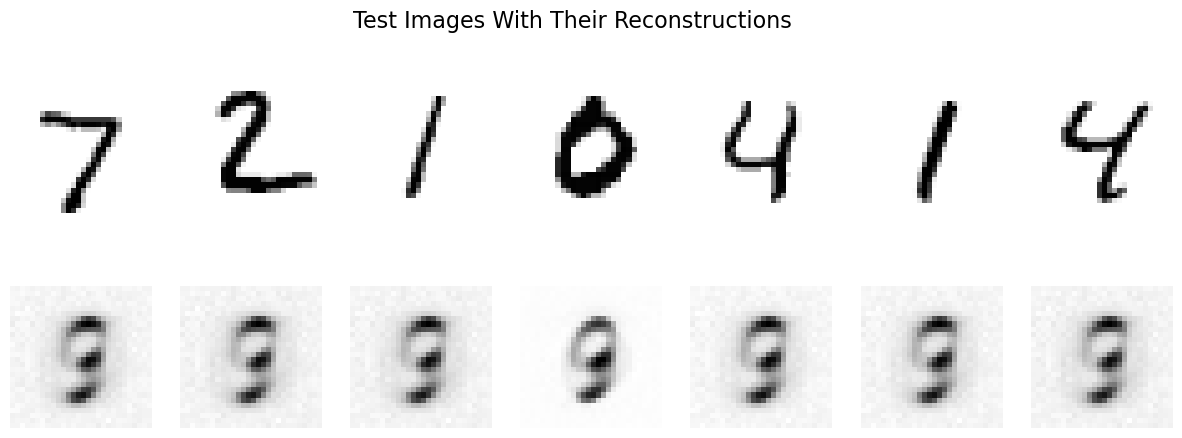

In [166]:
columns = 7
rows = 2
fig, axes = plt.subplots(rows, columns, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    if i >= columns:
        ax.imshow(reconstructed_test_imgs[i - columns]* -1, cmap='gray')
    else:
        ax.imshow(test_images_batch[i].squeeze()* -1, cmap='gray')
    ax.axis('off')
fig.suptitle('Test Images With Their Reconstructions', fontsize=16)
plt.savefig('200_epochs_no_correlation_loss/image_reconstructions.png', dpi=300)
plt.show()